# Load/import libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from preprocess import *
from lasso_fits import *
from rf_fits import *

## Download data for Rm = $1.5 \times 10^4$

In [3]:
#!wget -O mfields_R15e3.npz https://sid.erda.dk/public/archives/0cf0c2b6d34e20da8971304b06d8f913/pencil/alpha2/shock_k10_R15000_256_xyaver_alpha_eta/mfields.npz

In [4]:
# Time in resistive units for Rm=15e4 run
mf15 = np.load('mfields_R15e3.npz')
tres_R15e4=mf15['tt']/mf15['tres']
print(mf15['tres'])

149.09657903158052


In [5]:
# Time in resistive units for Rm=15e4 run
tres_R15e4=mf15['tt']/mf15['tres']
print(mf15['tres'])

149.09657903158052


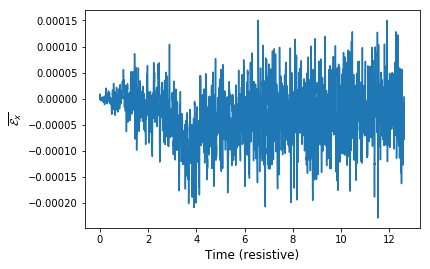

In [6]:
plt.plot(mf15['tt']/mf15['tres'],mf15['emfx'][:,192])
plt.xlabel('Time (resistive)', fontsize=12)
plt.ylabel(r'$\overline{\mathcal{E}_x}$', fontsize=12)
plt.savefig('emfx.pdf', bbox_inches='tight')

In [7]:
df15 = gen_df_zave_log(fname='mfields_R15e3.npz',z1=0)#,verbose=0)
#df05 = gen_df_zave_log(fname=pth + 'mfields_R5e2.npz', z1=0)#,verbose=0)

Generating z averaged dataframe with z1: 0 and z2: -1


/home/fnauman/python3/sklearn/paper_nbs/preprocess.py:155: RuntimeWarning: divide by zero encountered in log10
  'Ex2l': np.log10(ave_z(Exm**2,zone=z1,ztwo=z2)),
/home/fnauman/python3/sklearn/paper_nbs/preprocess.py:156: RuntimeWarning: divide by zero encountered in log10
  'Ey2l': np.log10(ave_z(Eym**2,zone=z1,ztwo=z2))


In [24]:
bxm,bym,jxm,jym,Exm,Eym = read_mf_norm(fname='mfields_R15e3.npz')

In [9]:
t1 = 0
t2 = -1
n_win = 20

In [25]:
me = (mf15['bxm'][n_win:-2]**2 + mf15['bym'][n_win:-2]**2)

In [11]:
Ex2l_rolmean = df15['Ex2l'].iloc[t1:t2].rolling(window=n_win).mean()
#print(Ex2l_rolmean.shape,Ex2l_rolmean.head(n_win))
#print(Ex2l_rolmean[n_win:].shape)

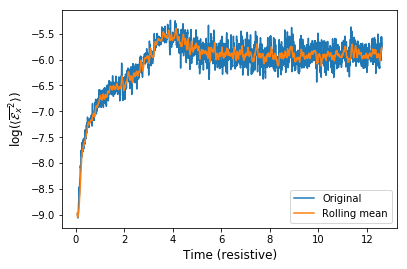

In [27]:
plt.plot(tres_R15e4[n_win:-2],np.log10(np.mean(mf15['emfx'][n_win:-2]**2,axis=1)/mf15['uave']**2), label='Original')
plt.plot(tres_R15e4[n_win:-2],Ex2l_rolmean[n_win:-1], label='Rolling mean')
plt.xlabel('Time (resistive)', fontsize=12)
plt.ylabel(r'$\log(\langle\overline{\mathcal{E}_x}^2\rangle)$', fontsize=12)
plt.legend()
plt.savefig('emfx2.pdf', bbox_inches='tight')

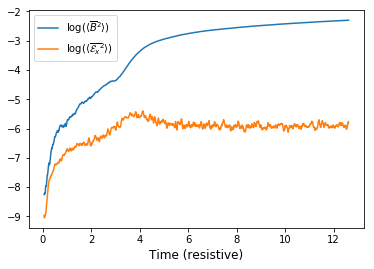

In [13]:
plt.plot(tres_R15e4[n_win:-2],np.log10(np.mean(me,axis=1)),label=r'$\log(\langle\overline{B}^2\rangle)$')  
#plt.plot(tres_R15e4[n_win:-2],np.log10(np.mean(mf15['emfx'][n_win:-2]**2/mf15['uave']**2,axis=1)), label='Original')
plt.plot(tres_R15e4[n_win:-2],Ex2l_rolmean[n_win:-1], label=r'$\log(\langle\overline{\mathcal{E}_x}^2\rangle)$')
plt.xlabel('Time (resistive)', fontsize=12)
#plt.ylabel(r'$\log(\langle\overline{\mathcal{E}_x}^2\rangle)$', fontsize=12)
plt.legend()
plt.savefig('log_emf_vs_b2.pdf', bbox_inches='tight')

In [14]:
t3 = int(2.0 * mf15['tres'])
Ex2l_kin_rolmean = df15['Ex2l'].iloc[t1:t3].rolling(window=n_win).mean()
#Ex2l_kin_rolmean.head(n_win)

t4 = int(8.0 * mf15['tres'])
Ex2l_sat_rolmean = df15['Ex2l'].iloc[t1:t4].rolling(window=n_win).mean()
#Ex2l_rolmean.iloc[n_win:].isna().sum() = 0

In [15]:
df_kin_win = (df15[t1:t3]).copy()
df_sat_win = (df15[t1:t4]).copy()

In [16]:
df_kin_win['Ex2l'] = Ex2l_kin_rolmean
df_sat_win['Ex2l'] = Ex2l_sat_rolmean

In [17]:
df_kin_win_nona = df_kin_win.iloc[n_win:,:]
df_sat_win_nona = df_sat_win.iloc[n_win:,:]

In [18]:
#df_sat_win.head()
df_kin_win_nona.tail()

,Bx2l,By2l,Jx2l,Jy2l,Ex2l,Ey2l
293,-3.671680,-3.718823,-1.464373,-1.484611,-6.886859,-7.095296
294,-3.670880,-3.725742,-1.469945,-1.469727,-6.882266,-6.950773
295,-3.668285,-3.723739,-1.475501,-1.475302,-6.872266,-6.817544
296,-3.666288,-3.718188,-1.487381,-1.464201,-6.867582,-6.765932
297,-3.667119,-3.707442,-1.488803,-1.438968,-6.860983,-6.802452


# Lasso

Test size: 0.2
Test,train shapes: (235, 4) (937, 4)
Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished


Means of CV folds: [-0.12847928 -0.12775924 -0.12475479 -0.15476838 -0.2379248 ]
STDs of CV folds : [0.02779976 0.02731645 0.01929938 0.01210504 0.08882446]
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.002266      0.000016         0.000685    2.503395e-06   
1       0.002142      0.000135         0.000696    3.170967e-05   
2       0.001696      0.000031         0.000620    4.768372e-07   
3       0.001641      0.000044         0.000648    3.576279e-07   
4       0.001697      0.000014         0.000648    9.417534e-06   

  param_lasso__alpha                   params  split0_test_score  \
0              0.001  {'lasso__alpha': 0.001}          -0.100680   
1               0.01   {'lasso__alpha': 0.01}          -0.100443   
2                0.1    {'lasso__alpha': 0.1}          -0.105455   
3                0.5    {'lasso__alpha': 0.5}          -0.142663   
4                  1    {'lasso__alpha': 1.0}          -0.149100   

   split1_test_score  mean_test

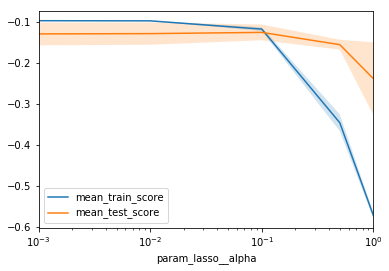

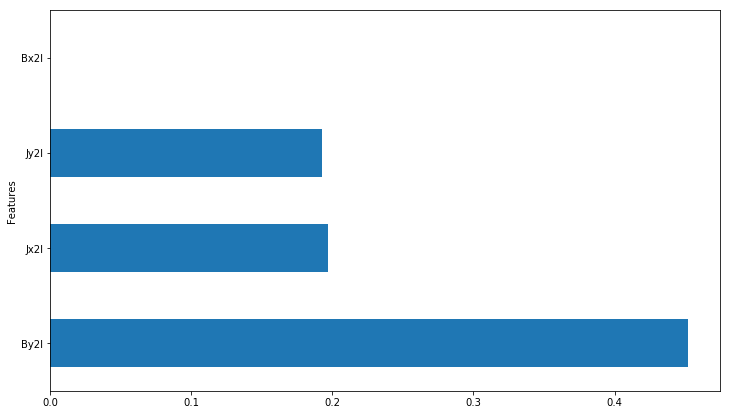

In [19]:
df15_ss, scl_las = scale_df(df_sat_win_nona)
y_train_lasso,y_pred_lasso,y_test_lasso = lasso_gridcv(df15_ss, test_size=0.2, fld='Ex2l',zave=True)

# Random forests

Test size: 0.2
Test,train shapes: (235, 4) (937, 4)
Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:    1.2s finished


Means of CV folds: [-0.05841547 -0.05841547 -0.05841547 -0.05841547 -0.05841547 -0.05841547
 -0.05841547 -0.05841547 -0.05841547 -0.05841547 -0.05841547 -0.05841547
 -0.06728129 -0.06145128 -0.06429948 -0.06632658 -0.07094004 -0.0675551
 -0.06404117 -0.06363506 -0.07454153 -0.06873243 -0.07046068 -0.07025797
 -0.05841547 -0.05841547 -0.05841547 -0.05841547 -0.05841547 -0.05841547
 -0.05841547 -0.05841547 -0.05841547 -0.05841547 -0.05841547 -0.05841547
 -0.07602023 -0.07607071 -0.07603667 -0.07600022 -0.06895615 -0.06895615
 -0.06895615 -0.06895615 -0.05137027 -0.05137027 -0.05137027 -0.05137027
 -0.06587359 -0.06288625 -0.06086851 -0.06066138 -0.0675691  -0.06251179
 -0.06193347 -0.05991596 -0.06152614 -0.05895289 -0.05739958 -0.05625153
 -0.07602023 -0.07607071 -0.07603667 -0.07600022 -0.06895615 -0.06895615
 -0.06895615 -0.06895615 -0.05137027 -0.05137027 -0.05137027 -0.05137027]
STDs of CV folds : [0.01828458 0.01828458 0.01828458 0.01828458 0.01828458 0.01828458
 0.01828458 0.01828

<Figure size 432x288 with 0 Axes>

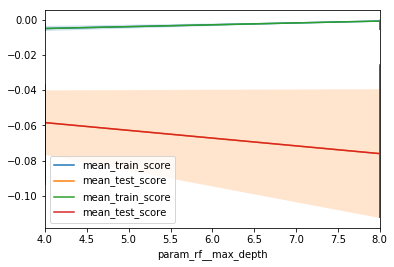

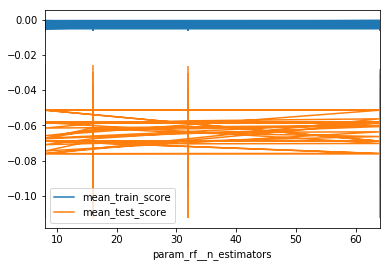

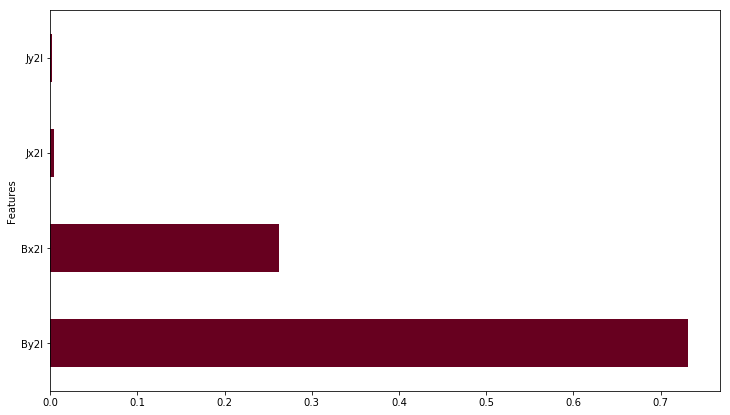

In [20]:
y_train_rf,y_pred_rf,y_test_rf = rf_gridcv(df_sat_win_nona, fld='Ex2l', zave=True, err_metric='mse')

In [21]:
tres_plt = tres_R15e4[n_win:y_train_rf.shape[0] + n_win + y_pred_rf.shape[0]]

print(df_sat_win_nona['Ex2l'].shape, tres_plt.shape)

(1172,) (1172,)


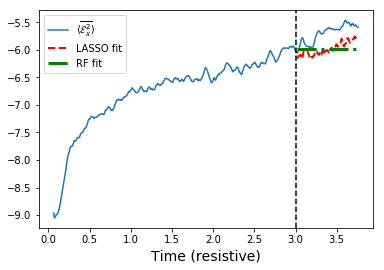

In [22]:
fig, ax = plt.subplots()
        
y_pred_lasso2 = y_pred_lasso * scl_las.scale_[np.newaxis,4] + scl_las.mean_[np.newaxis,4]
    
fld_label = r"$\langle \overline{\mathcal{E}_x^2}\rangle$" #if fld=='Ex' else r"$\mathcal{E}_y$"
        
# Change df_kin to df_sat for saturated fits!!
ax.plot(tres_plt,df_sat_win_nona['Ex2l'],label=fld_label)
#ax.plot(tres_plt[:y_train.shape[0]],y_trainrf,'r',lw=3,label="Train data")
#ax.plot(tres_plt[y_train.shape[0]:],y_testrf,label="Test data")
ax.plot(tres_plt[y_train_lasso.shape[0]:], y_pred_lasso2, 'r--', lw=2, label="LASSO fit")
ax.plot(tres_plt[y_train_rf.shape[0]:], y_pred_rf, 'g-.', lw=3, label="RF fit")
plt.axvline(x=0.8*tres_plt[-1], color='k', linestyle='--')

ax.legend()
ax.set_xlabel('Time (resistive)',fontsize=14)
    
fig.savefig('df15_TIME_sat_comparison.pdf',bbox_inches='tight')

In [23]:
list(mf15)

['tres',
 'Rm',
 'uave',
 'kf',
 'tt',
 'bxm',
 'bym',
 'b2tot',
 'u2tot',
 'emfx',
 'emfy',
 'jxm',
 'jym']